In [277]:
# 1. Basic setup
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [278]:
def load_data_from_folders(paths):
    emotion_map = {
        '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
        '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
    }

    def get_emotion(filename):
        emotion_code = filename.split("-")[2]
        return emotion_map[emotion_code]

    file_list = []
    for path in paths:
        for root, _, files in os.walk(path):
            for file in files:
                if file.endswith(".wav"):
                    emotion = get_emotion(file)
                    file_path = os.path.join(root, file)
                    file_list.append((file_path, emotion))
    return pd.DataFrame(file_list, columns=["path", "emotion"])

DATA_PATH_1 = "Audio_Song_Actors_01-24" 
# DATA_PATH_2 = "Audio_Speech_Actors_01-24"

df = load_data_from_folders([DATA_PATH_1])
print("Total files loaded:", len(df))
print(df.head())


Total files loaded: 1012
                                                path  emotion
0  Audio_Song_Actors_01-24\Actor_01\03-02-01-01-0...  neutral
1  Audio_Song_Actors_01-24\Actor_01\03-02-01-01-0...  neutral
2  Audio_Song_Actors_01-24\Actor_01\03-02-01-01-0...  neutral
3  Audio_Song_Actors_01-24\Actor_01\03-02-01-01-0...  neutral
4  Audio_Song_Actors_01-24\Actor_01\03-02-02-01-0...     calm


<Axes: xlabel='emotion'>

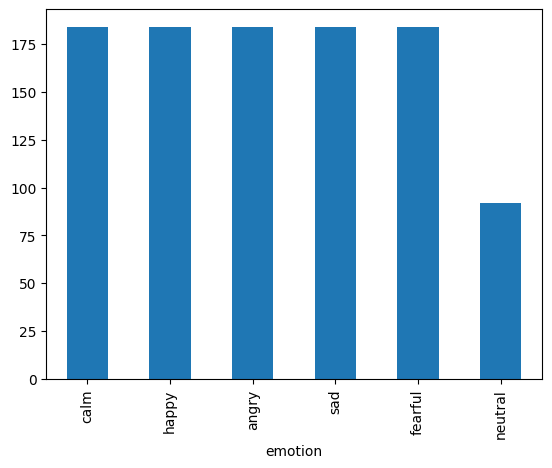

In [279]:
df['emotion'].value_counts().plot(kind='bar')


In [280]:
import librosa

test_path = df.iloc[0]["path"]
print("Trying:", test_path)

# Try loading
audio, sr = librosa.load(test_path, sr=None)
print("Duration (s):", len(audio) / sr)


Trying: Audio_Song_Actors_01-24\Actor_01\03-02-01-01-01-01-01.wav
Duration (s): 4.237583333333333


In [281]:
import librosa

test_path = df.iloc[0]["path"]
test_path = os.path.normpath(test_path)  # normalize path in case of backslashes

try:
    audio, sr = librosa.load(test_path, sr=None)
    print("Audio shape:", audio.shape)
    print("Sample rate:", sr)
except Exception as e:
    print("Librosa failed:", e)


Audio shape: (203404,)
Sample rate: 48000


In [282]:
def extract_features(file_path, max_pad_len=174):
    try:
        audio, sample_rate = librosa.load(file_path, sr=22050)  # Resample
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        
        # Padding or truncating
        if mfcc.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_pad_len]
        
        return mfcc
    except Exception as e:
        print(f"[ERROR] {file_path} => {e}")
        return None



In [283]:
X = []
y = []

for index, row in tqdm(df.iterrows(), total=len(df)):
    features = extract_features(row["path"])
    if features is not None:
        X.append(features)
        y.append(row["emotion"])

X = np.array(X)
X = X[..., np.newaxis]
print("Shape of X:", X.shape)
print("Sample label:", y[0])




100%|██████████| 1012/1012 [00:19<00:00, 50.65it/s]

Shape of X: (1012, 40, 174, 1)
Sample label: neutral


In [284]:
le = LabelEncoder()
y_encoded = to_categorical(le.fit_transform(y))
print("Encoded labels:", y_encoded.shape)


Encoded labels: (1012, 6)


In [285]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


In [286]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()

# Conv Layer 1
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(40, 174, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Conv Layer 2
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Flatten and Dense
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_encoded.shape[1], activation='softmax'))  # num_classes output


In [287]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_test, y_test)
)


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.1868 - loss: 46.8305 - val_accuracy: 0.1921 - val_loss: 1.7899
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.1970 - loss: 1.8065 - val_accuracy: 0.1773 - val_loss: 1.7870
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.2086 - loss: 1.8149 - val_accuracy: 0.1970 - val_loss: 1.7871
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.1552 - loss: 1.8065 - val_accuracy: 0.2512 - val_loss: 1.7757
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.2615 - loss: 1.7361 - val_accuracy: 0.3547 - val_loss: 1.6400
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.3223 - loss: 1.6103 - val_accuracy: 0.4975 - val_loss: 1.2511
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.4792 - loss: 1.3193 - val_accuracy: 0.6305 - val_loss: 0.9876
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.5136 - loss: 1.1371 - val_accuracy: 0.6749 -

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
              precision    recall  f1-score   support

       angry       0.97      0.95      0.96        37
        calm       0.94      0.92      0.93        37
     fearful       0.81      0.78      0.79        37
       happy       0.92      0.95      0.93        37
     neutral       1.00      1.00      1.00        18
         sad       0.82      0.86      0.84        37

    accuracy                           0.90       203
   macro avg       0.91      0.91      0.91       203
weighted avg       0.90      0.90      0.90       203



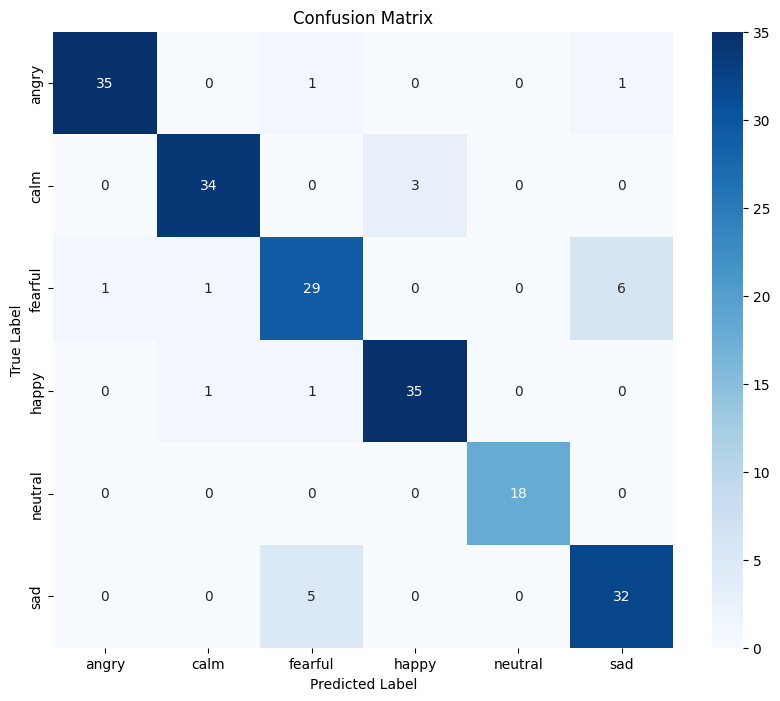

In [288]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predictions
y_pred = model.predict(X_test)
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_test_labels, y_pred_labels, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


In [289]:
# import joblib
# model.save('my_model.keras')
# joblib.dump(le, "label_encoder.pkl")


In [290]:
def get_type_from_filename(filename):
    vocal_channel = filename.split("-")[2]
    return vocal_channel

In [292]:
import joblib
file_type = get_type_from_filename(df.iloc[0]["path"])
print("File type:", file_type)

if file_type == "01":
    model.save("model/speech_model/emotion_model_speech.h5")
    joblib.dump(le, "model/speech_model/label_encoder_speech.pkl")
else:
    model.save("model/song_model/emotion_model_song.h5")
    joblib.dump(le, "model/song_model/label_encoder_song.pkl")


File type: 02
